In [1]:
# import numpy as set the random seed
import numpy as np
np.random.seed(42)
# for dummy data set generation
from sklearn.datasets import make_regression 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

In order to perform hamiltonian sampling we need two functions:

1. A function returning the unnormalized log-posterior
1. A function returning the gradient of the unnormalized log-posterior at the given location

After these two functions are implemented, all we need to do is to perform the leapfrog integration taking care of:
1. Specifying the number of integration steps and
1. Specifying the step size

The conceptual part is not that difficult. I will not implement it here. What I want to do is to sample from the posterior distribution of a linear model.

We take into consideration again the linear model that I implemented for the quadratic approximation.

In [2]:
X, y = make_regression(n_samples=100,n_features=2, bias=0.0, noise=20)

In [3]:
from sklearn.linear_model import LinearRegression
mod = LinearRegression(fit_intercept=False).fit(X,y)
print(mod.coef_)

[84.19968933 74.17314929]


This create the suitable data for regression

In [4]:
def U(pars,a=1, b=1, lam = 0.01):
    # this function evaluates the log-posterior in a linear regression model.
    # the source is: https://tinosai.github.io/2022/09/23/Quadratic-Approximation.html
    # note that here we are evaluating the log-posterior, and not the negative log-posterior.
    beta = np.array(pars[:2])
    sigma2 = pars[2]
    if pars[2] <=0:
        # returns infinite negative logp when sigma^2 <= 0
        return np.inf
    V = 1/lam * np.eye(X.shape[1])
    # logpdf of sigma
    logp  = scio.invgamma( a = a, scale = b).logpdf(sigma2)
    # logpdf of beta
    logp += scio.multivariate_normal(mean = np.zeros(beta.shape), cov = sigma2*V).logpdf(beta)
    # log likelihood
    logp += scio.multivariate_normal(mean = np.squeeze(X@beta.reshape(-1,1)), 
                                     cov=sigma2*np.eye(X.shape[0])).logpdf(y)
    return -logp

In [5]:
import scipy.stats as scio
U([0,0,1])

571842.8862133338

Numpy and scipy match!

So, the function is objectively quite nasty. We need to find the partial derivatives of the log-posterior above with respect to $\beta$ (an $\mathbb{R}^2$ vector) and $\sigma^2$. Which means that the gradient vector is and $\mathbb{R}^3$ vector. In my opinion, focusing on this part takes away a lot of the intuition behind Hamiltonian Monte Carlo. Auto-differentiation and symbolic differentiation are two excellent tools which abstract away the problem of calculating the gradient. 
The calculation of the gradient with finite differences, although not very accurate, is much more familiar and it is exactly what I have decided to adopt here.

In [6]:
def dU(pars,a=1, b=1, lam = 0.01, d=[1e-6]*3):
    # this function calculates the gradient with centered finite difference
    # df/dx = (f[x+h]-f[x-h])/2h
    pars = np.array(pars)
    out = np.zeros_like(pars)
    for i in range(len(pars)):
        dpars = np.copy(pars)
        # move in the positive direction
        # calculate f[x+h]
        dpars[i] += d[i]
        u_plus = U(dpars,a=a, b=b, lam = lam)
        # move int he negative direction (twice to go back and to move)
        # calculate f[x-h]
        dpars[i] -= 2*d[i]
        u_minus = U(dpars,a=a, b=b, lam = lam)
        # calculate centered gradient
        # (f[x+h]-f[x-h])/2h
        out[i] = (u_plus - u_minus) / (2*d[i])
    return out

In [7]:
dU([0.0,0.0,1.0])

array([  -6398.68516009,   -7532.32056741, -571691.54926669])

In [8]:
def dU(pars,a=1,b=1,lam=0.01):
    # this function evaluates the gradient of the unnormalized negative log-posterior
    sigma2 = pars[-1]
    beta = np.array(pars[:-1]).reshape(-1,1)
    p = beta.shape[0]
    n = X.shape[0]
    V_inv = lam * np.eye(beta.shape[0])
    
    # derivative with respect to beta
    dudbeta = 1/sigma2 * X.T@(y.reshape(-1,1)-X@beta) -1/sigma2*V_inv@beta
    
    # derivative with respect to the noise
    duds2  = - p/(2*sigma2) + 1/(2*sigma2**2.0)*beta.T@V_inv@beta + ((1.0-a)*sigma2+b)/(sigma2**2.0)
    duds2 +=  -n/(2*sigma2) + 1/(2*sigma2**2.0)*(y.reshape(-1,1)-X@beta).T@(y.reshape(-1,1)-X@beta)
    
    # concatenate the gradients from beta and sigma^2
    output = np.concatenate([dudbeta,duds2])
    
    return -np.squeeze(output)

In [9]:
dU([0,0,1])

array([  -6398.68519251,   -7532.32053796, -571693.54931276])

Again, this routine is ok but not optimal. If we had autodiff or if be bothered to calculate the analytic derivative, the local gradients would be exact. But the analytic derivative are nasty, quite long, and they bring very little benefit. I argue that, given that the purpose of the notebook is not to build an optimized HMC sampler, this level of detail should be enough

Next thing to implement is the leapfrog integration

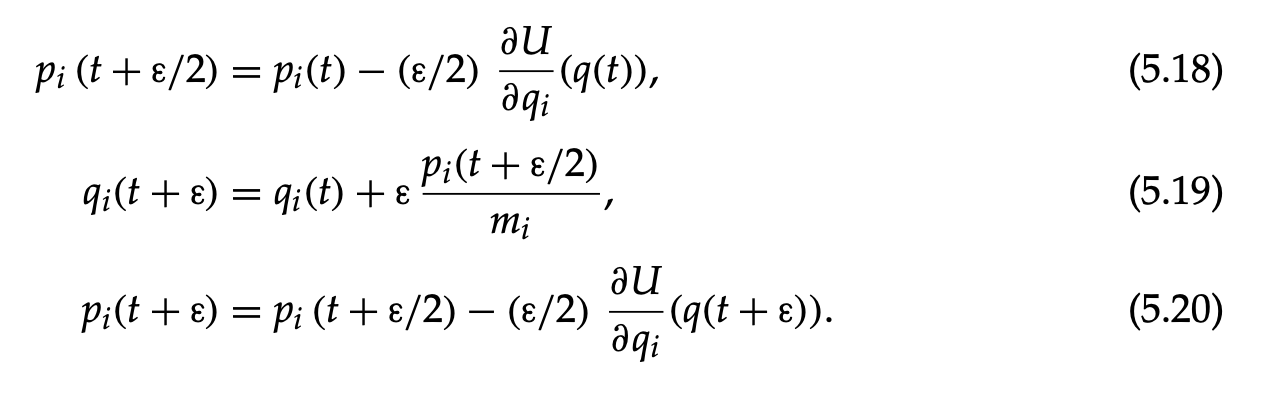

The picture above is taken from "The Handbook of Markov Chain Monte Carlo"

We need to decide $\epsilon$ and the number of leapfrog steps L to perform.

In [10]:
dU(np.array([0,0,1.0]))

array([  -6398.68519251,   -7532.32053796, -571693.54931276])

In [11]:
def leapFrog(q,epsilon=0.00001, L=10):
    """
    Performs the leapFrog integration step.
    Inputs:
        q       : a vector of parameters [d+1]
        epsilon : the integration step size 
        L       : the number of leapFrog integration steps
    Output:
        the accepted value for the parameters after the Metropolis proposal
    """
    
    # 0. copy global variables in local scope
    localQ = np.copy(q)
    
    # 1. Sample the momentum p from a standard normal distribution
    localP = np.random.normal(size=len(q)) 
    p = np.copy(localP)
    
    # 2. In accordance to the leapfrog integration, make a half step at the beginning
    localP -= epsilon/2*dU(localQ)
    
    # 3. Perform L integration steps
    for i in range(1,L+1):
        localQ += epsilon*localP
        # if we are not at the last step, perform full-step integration of the momentum
        if i != L:
            localP -= epsilon*dU(localQ)
    # 4. at the last step, we perform half-step integration of the momentum instead
    localP -= epsilon/2*dU(localQ)
    
    # 5. check the hamiltonian at the start and at the end
    initial_U = U(q)
    initial_K = np.sum(p**2.0) / 2.0
    final_U = U(localQ)
    final_K = np.sum(localP**2.0) / 2.0
    
    # 6. perform the Metropolis acceptance 
    if np.random.uniform() < np.exp((initial_U-final_U+initial_K-final_K)):
        
        return localQ
    else:
        return q

In [12]:
import tqdm

In [13]:
ext = np.array([10.0,10.0,100.0])
ext_bef = np.copy(ext)
print(ext)
accept_rate = 0
samples = []
for i in tqdm.tqdm(range(20000)):
    ext_bef = np.copy(ext)
    ext = leapFrog(ext, epsilon=2.1 ,L=20)
    if ~np.all(ext == ext_bef):
        samples.append(ext)
        #print("entered")
        #print(ext)
        #print(i)
        #accept_rate += 1/100
        
print(accept_rate)

[ 10.  10. 100.]


100%|████████████████████████████████████| 20000/20000 [02:01<00:00, 164.03it/s]

0


In [14]:
samples

[array([ -24.59239659,   82.53496439, 3436.98507546]),
 array([ -24.26969599,   74.05904621, 3467.64072705]),
 array([ -24.14099722,   73.14712355, 3442.72228832]),
 array([ -22.77528576,   72.28481395, 3511.96179296]),
 array([ -20.9874711 ,   73.13986074, 3503.10623998]),
 array([ -18.85935138,   70.5908625 , 3573.67316241]),
 array([ -15.44104661,   67.95405005, 3563.14507158]),
 array([ -11.00772306,   68.7298979 , 3498.54330708]),
 array([  -8.70938345,   70.68539165, 3570.45795738]),
 array([  -4.05188668,   67.70331313, 3579.28524463]),
 array([-4.35640044e-01,  7.77052602e+01,  3.55265467e+03]),
 array([-8.77663167e-01,  7.65951211e+01,  3.55526760e+03]),
 array([6.83772111e-01, 7.59454465e+01, 3.62232993e+03]),
 array([   4.3160708 ,   83.27817573, 3645.49374615]),
 array([   9.6743469 ,   79.40307188, 3615.48160932]),
 array([  13.78365371,   80.47967977, 3600.94149614]),
 array([  15.91556413,   78.65866296, 3649.8695724 ]),
 array([  19.14765969,   76.62796591, 3751.4914044

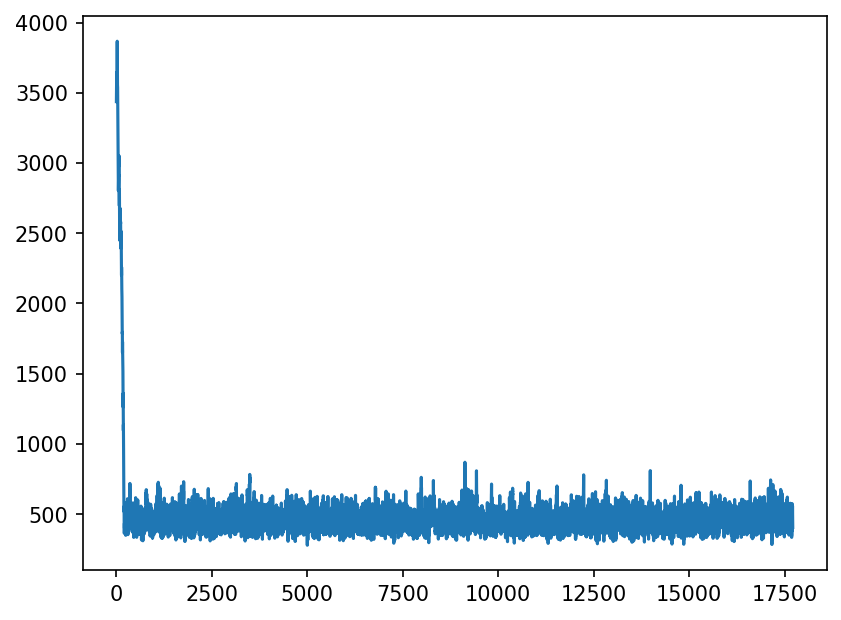

In [15]:
plt.plot(np.vstack(samples)[:,2])

In [16]:
a, b = 1.0,1.0
lam = 0.01
V = 1/lam * np.eye(X.shape[1])
n = X.shape[0]
Vn = np.linalg.pinv(np.linalg.pinv(V)+X.T@X)
mn = Vn@X.T@y
an = a+n/2
bn = b+0.5*(np.dot(y,y)-np.dot(y,X@mn))

# sample from the exact posterior
sigma2_post = 1/scio.gamma(a=an, scale=1/bn).rvs(10000)
beta_post = np.zeros((2,sigma2_post.shape[0]))
for i, sigma2_eval in enumerate(sigma2_post):
    beta_post[:,i] = scio.multivariate_normal(mean=mn, cov=sigma2_eval*Vn).rvs()

# output the exact posterior
exact_posterior = np.vstack((beta_post, sigma2_post)).T

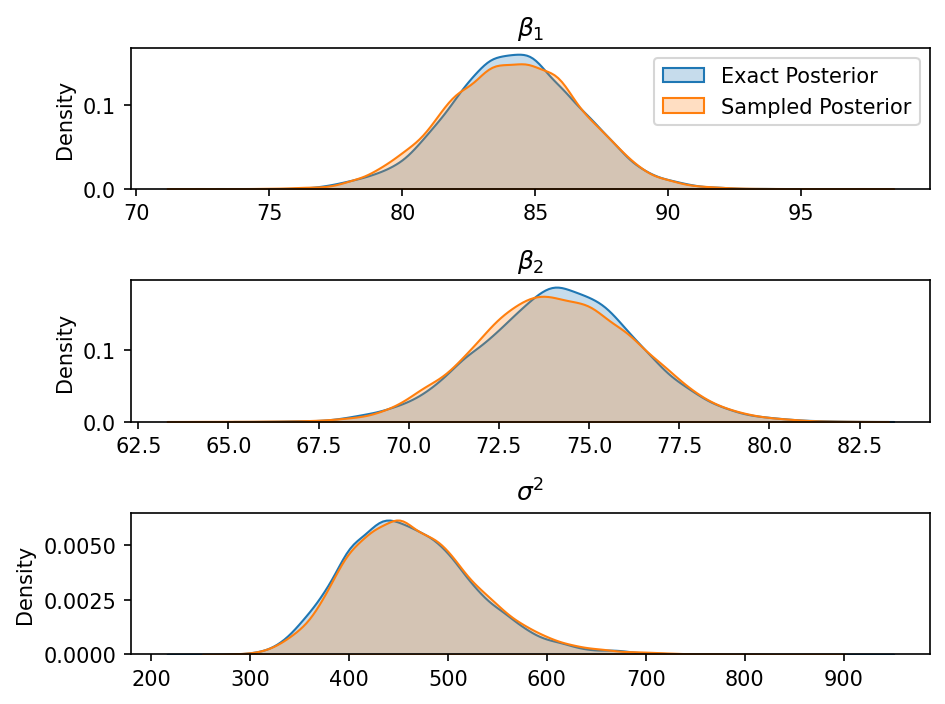

In [44]:
# create the axes
fig, ax = plt.subplots(nrows=3)
# plot the distribution of beta_1
sns.kdeplot(exact_posterior[-10000:,0],fill=True, ax=ax[0], label="Exact Posterior")
sns.kdeplot(samples[-10000:,0],fill=True, ax=ax[0], label="Sampled Posterior")
ax[0].set_title("$\\beta_{1}$")
ax[0].legend()

# plot the distribution of beta_2
sns.kdeplot(exact_posterior[-10000:,1],fill=True, ax=ax[1])
sns.kdeplot(samples[-10000:,1],fill=True, ax=ax[1])
ax[1].set_title("$\\beta_2$")

# plot the distribution of sigma^2
sns.kdeplot(sigma2_post[-10000:],fill=True, ax=ax[2])
sns.kdeplot(samples[-10000:,2],fill=True, ax=ax[2])
ax[2].set_title("$\sigma^2$")

plt.tight_layout()

In [ ]:
plt.hist(sigma2_post[:], bins=np.linspace(0,800,100), alpha=0.5);
plt.hist(np.vstack(samples)[-10000:,2], bins=np.linspace(0,800,100), alpha=0.5)